<a href="https://colab.research.google.com/github/jrakhshanda/Text-Mining/blob/main/text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Sentiment Extraction

In [ ]:
!pip install emot
!pip install tokenizers
!pip install transformers

In [22]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [23]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [51]:
print(df_train.shape)
df_train.sample(5)

(27481, 4)


,textID,text,selected_text,sentiment
19583,b6e139c70f,perfect,perfect,positive
21742,17de4b411b,"great,","great,",positive
9938,5d6c718979,y must i hve graduation practice...all im gonn...,y must i hve graduation practice...all im gonn...,neutral
2818,569fceca58,My stomach effing hurts. Sadly there`ll be no ...,My stomach effing hurts. Sadly there`ll be no ...,negative
23709,9e7b2503b9,sad!,sad!,negative


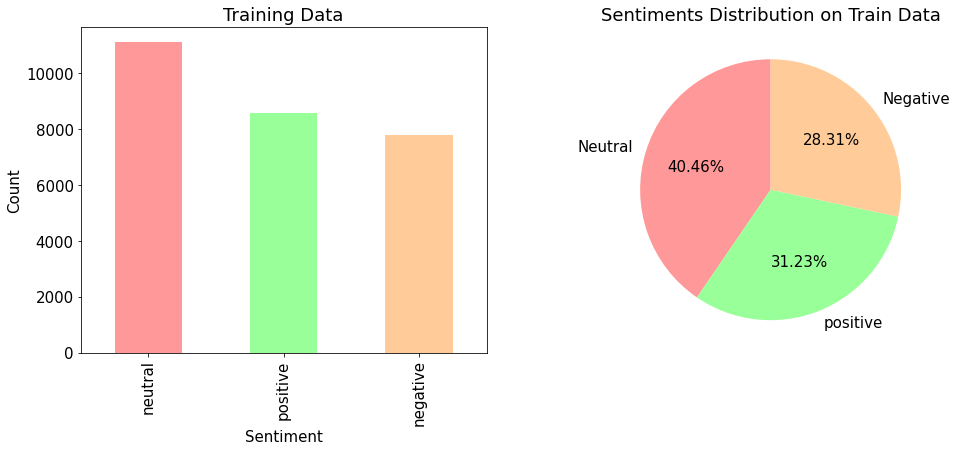

In [25]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
df_train["sentiment"].value_counts().plot(kind='bar',color = ['#ff9999','#99ff99','#ffcc99'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title('Training Data')

lst1 = [df_train.sentiment[df_train.sentiment == 'neutral'].count(),
        df_train.sentiment[df_train.sentiment == 'positive'].count(),
        df_train.sentiment[df_train.sentiment == 'negative'].count()]
        
plt.subplot(1, 2, 2)
plt.pie(lst1, labels=["Neutral", "positive", "Negative"], startangle=90, autopct='%.2f%%',colors=['#ff9999','#99ff99','#ffcc99'])
plt.title('Sentiments Distribution on Train Data')
plt.show()

In [50]:
print(df_test.shape)
df_test.sample(6)

(3534, 3)


,textID,text,sentiment
1136,a1ac7a0543,don`t think i can take a needle. watched a hor...,negative
2505,2b2f63eb2c,Ok NOW I can hit the hay. Thank you,positive
1167,b2bada7873,And you as well bro,neutral
2132,a2c8b8dad7,won`t be going to the Oxford Internet Institut...,negative
1295,3e99f423ba,"poor you lmao, just stick your head out the wi...",negative
674,4c086d6a58,will b having my last V tomorow will have2live...,neutral


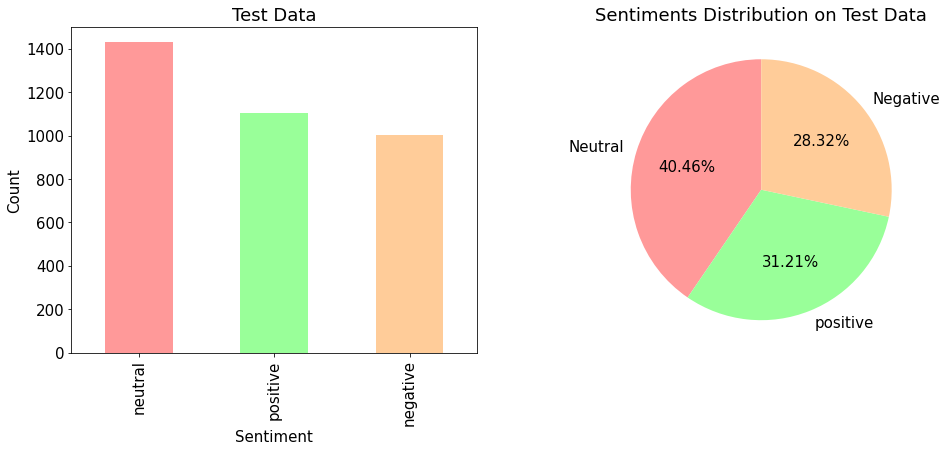

In [15]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
df_test["sentiment"].value_counts().plot(kind='bar',color = ['#ff9999','#99ff99','#ffcc99'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title('Test Data')

lst1 = [df_test.sentiment[df_test.sentiment == 'neutral'].count(),
        df_test.sentiment[df_test.sentiment == 'positive'].count(),
        df_test.sentiment[df_test.sentiment == 'negative'].count()]
plt.subplot(1, 2, 2)
plt.pie(lst1, labels=["Neutral", "positive", "Negative"], startangle=90, autopct='%.2f%%',colors=['#ff9999','#99ff99','#ffcc99'])
plt.title('Sentiments Distribution on Test Data')
plt.show()

## Pre-processing of the Data

In [16]:
from bs4 import BeautifulSoup
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [31]:
def clean_data(text):

  """remove URL, remove HTML tags and convert emojis.

    Args:
        text: A string of text.
  
  """
  text = str(text).lower()
  text = " " + " ".join(str(text).split())
  text = re.sub('\n', '', text)
  text = BeautifulSoup(text,"lxml").get_text() # removing HTML tags
  text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL
  for emot in UNICODE_EMO:  # replacing emoji with its actual expression of text
    text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))

  return text

In [57]:
df_train.dropna()
df_test.dropna()

df_train['text'] = [clean_data(i) for i in df_train['text']]
df_train['text'] = [clean_data(i) for i in df_train['selected_text']]

df_test['text'] = [clean_data(i) for i in df_test['text']]
df_test['text'] = [clean_data(i) for i in df_test['text']]

In [55]:
df_train.sample(5)

,textID,text,selected_text,sentiment
6692,77e8ffdd9b,why did i agree to work a double shift,why did i agree to work a double shift,neutral
22119,1dd93ad2be,wishes she would call him ... *hc*,wishes she would call him ... *hc*,neutral
25737,55e361033a,It should take you back to colorado where you ...,It should take you back to colorado where you ...,neutral
21021,35b3161006,loves,loves,positive
327,4c71b5fb91,now a migraine.,now a migraine.,negative


In [56]:
df_test.insert(2,'selected_text',np.nan)

##Tokenization

We are constructing a RoBERTa tokenizer, derived from the GPT-2 tokenizer, using byte-level Byte-Pair-Encoding.

[refrence](https://huggingface.co/transformers/model_doc/roberta.html#)

[source](https://huggingface.co/transformers/_modules/transformers/models/roberta/tokenization_roberta.html#RobertaTokenizer)

In [ ]:
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers

In [44]:
from transformers import RobertaTokenizer
max_len = max([len(i) for i in df_train['text']])
TTrain_batch_size = 32
valid_batch_size = 8
epochs = 5
tokenizer = RobertaTokenizer(vocab_file = 'roberta-base-vocab.json',
                             merges_file = 'roberta-base-merges.txt',
                             add_prefix_space=True, lowe_case = True)


In [ ]:
#def tokenize_data(df, tokenizer, max_len):

df = df_train
n = df.shape[0]

input_ids = np.ones((n,max_len),dtype='int32')
attention_mask = np.zeros((n,max_len),dtype='int32')
token_type_ids = np.zeros((n,max_len),dtype='int32')
beg_tokens = np.zeros((n,max_len),dtype='int32')
end_tokens = np.zeros((n,max_len),dtype='int32')

for i in range(n):

  # FIND OVERLAP OR INTERSECTIONOF BOTH THE TEXTS
  text = " "+" ".join(df.loc[i,'text'].split()) # yields a whitespace at beginning of text
  selected_text = " ".join(df.loc[i,'selected_text'].split())

  idx = text.find(selected_text)
  chars = np.zeros((len(text)))
  chars[idx:idx+len(selected_text)]=1
  if text[idx-1]==' ': chars[idx-1] = 1 
  enc = tokenizer.encode(text) 

In [66]:
len(s1)

3